# IRC Behavioral Analysis

### Imports

In [3]:
import zat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from zat.log_to_dataframe import LogToDataFrame
from zat.bro_log_reader import BroLogReader
from collections import defaultdict

## Loading Data

In [21]:
import os

logs = ['03','04','34','39','42','51','56','62','irc1']
log_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/'

logs_fn_join = [os.path.join(log_dir,l,'irc_join.log') for l in logs]
logs_fn_privmsg = [os.path.join(log_dir,l,'irc_privmsg.log') for l in logs]

In [22]:
def load_logs(file: str) -> list:
    logs_arr = []
    if not os.path.isfile(file):
        return logs_arr
    reader = BroLogReader(file)

    for log in reader.readrows():
        # log is in dictionary format
        logs_arr.append(log)

    return logs_arr

In [23]:
logs_join = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join = list(filter(lambda x: len(x) != 0 ,logs_join))

logs_privmsg = list(map(lambda x: load_logs(x),logs_fn_privmsg))
logs_privmsg = list(filter(lambda x: len(x) != 0 ,logs_privmsg))

Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/04/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/34/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/39/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/42/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/51/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/56/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratosphere/IRC-research/IRC-Behavioral-Analysis/zeek/logs/62/irc_join.log...
Successfully monitoring /Users/preneond/Documents/Work/Stratos

## Number of Users in Channel per Day

In [24]:
from pandas.plotting import register_matplotlib_converters
>>> register_matplotlib_converters()

def ircjoin_visualize(logs: list):
    logs_ts = list(map(lambda x: x['ts'].date(), logs))

    # first ts of join command
    ts_min = min(logs_ts)
    ts_max = max(logs_ts)
    print('min date: {}, max date: {}'.format(ts_min, ts_max))
    span = ts_max - ts_min
    
    dates = [ts_min+timedelta(days=i) for i in range(span.days+1)]

    ## count how many join commands are in which day 
    logs_per_day = defaultdict(lambda: 0)
    for v in logs_ts:
        logs_per_day[v] += 1
    
    dates_count = []
    count = 0
    for d in dates:
        count += logs_per_day[d]
        dates_count.append(count)
    

    plt.bar(dates,dates_count)
    plt.show()

min date: 2019-01-09, max date: 2019-01-14


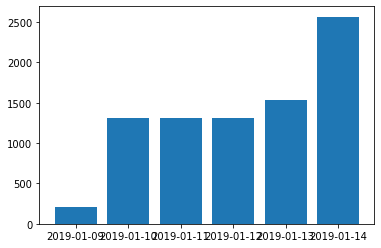

In [8]:
# import random
log = logs_join[2]
ircjoin_visualize(log)

## Levenshtein Distance of Messages in Channel

In [25]:
import itertools
from Levenshtein import distance as levenshtein_distance

def compute_levenshtein_distance(logs: list) -> float:
    logs_msg = list(map(lambda x: x['msg'], logs))
    dist_lev_arr = []
    for msg1, msg2 in itertools.combinations(logs_msg,2):
        dist_lev_arr.append(levenshtein_distance(msg1,msg2))
    
    return np.mean(dist_lev_arr) if len(dist_lev_arr) > 0 else 0

### Bubble plot



In [26]:
n = len(logs_privmsg)


logs_sources = []
logs_messages = []
logs_lev_dist = []

for logs in logs_privmsg:
    # compute levenshtein distance
    lev_dist = compute_levenshtein_distance(logs)
    logs_lev_dist.append(lev_dist)
    print('lev_dist: ', lev_dist)

    # # compute number of days per each malware
    # logs_ts = list(map(lambda x: x['ts'].date(), logs))
    # span = max(logs_ts) - min(logs_ts)
    # logs_days.append(span.days+1)
    # print('days: ', span.days+1)
    
    # compute number of msg's senders per channel
    sources = set()
    for log in logs:
        sources.add(log['source'])
    
    print('sources: ', len(sources))
    logs_sources.append(len(sources))
    
    # compute number of msgs per channel
    logs_messages.append(len(logs))
    print('messages: ', len(logs))

lev_dist:  46.57957790192427
sources:  6
messages:  180
lev_dist:  0
sources:  1
messages:  1
lev_dist:  29.403408881291735
sources:  4
messages:  699
lev_dist:  14.299157070345938
sources:  9
messages:  2022
lev_dist:  27.437229437229437
sources:  4
messages:  22


In [ ]:
print('# Sources:\t{} \n# Messages:\t\t{} \nLev dist:\t{}'.format(logs_sources, logs_days, logs_lev_dist))

In [ ]:
cm = plt.cm.get_cmap('jet')

x = np.array(logs_sources)
y = np.array(logs_messages)
z = 5*np.power(np.array(logs_lev_dist),2)

fig, ax = plt.subplots()
sc = ax.scatter(x,y,s=z,c=z,cmap=cm)
ax.grid(alpha=0.5)
fig.colorbar(sc)
plt.xlabel('Number of Users in Channel')
plt.ylabel('Number of Messages')
plt.title('Levenstein Distance of Messages per Capture')
plt.show()